In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import keras
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers.core import Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

from keras.utils import plot_model, to_categorical

Using TensorFlow backend.


In [2]:
pd.options.display.float_format = '{:0.2f}'.format

In [3]:
df = pd.read_csv("FX_MA_5days.csv")
df.head()

,time,open,high,low,close,5mean,target
0,2019-01-08 07:00:00,108.72,109.09,108.44,108.73,108.50,0
1,2019-01-09 07:00:00,108.75,109.01,107.97,108.16,108.36,0
2,2019-01-10 07:00:00,108.14,108.52,107.77,108.43,108.51,1
3,2019-01-11 07:00:00,108.43,108.60,108.15,108.51,108.51,0
4,2019-01-14 07:00:00,108.56,108.57,107.99,108.16,108.40,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 7 columns):
time      240 non-null object
open      240 non-null float64
high      240 non-null float64
low       240 non-null float64
close     240 non-null float64
5mean     240 non-null float64
target    240 non-null int64
dtypes: float64(5), int64(1), object(1)
memory usage: 13.2+ KB


In [5]:
df['target'].value_counts()

1    127
0    113
Name: target, dtype: int64

In [6]:
# 時間表記スライシング
def timechange(time):
    time = "".join(str(time)[:10])
    return time

In [7]:
df['time'] = df['time'].apply(lambda x: timechange(x))
df = df.rename(columns={'time':'date'})
df.head()

,date,open,high,low,close,5mean,target
0,2019-01-08,108.72,109.09,108.44,108.73,108.50,0
1,2019-01-09,108.75,109.01,107.97,108.16,108.36,0
2,2019-01-10,108.14,108.52,107.77,108.43,108.51,1
3,2019-01-11,108.43,108.60,108.15,108.51,108.51,0
4,2019-01-14,108.56,108.57,107.99,108.16,108.40,0


In [8]:
#　Twitterデータ取得
tweet = pd.read_csv('../NLP/trumptweep.csv')
del tweet['Unnamed: 0']
tweet.head()

,date,tweet
0,2019-07-14,"https://t.co/YaiCXrxYQq .....Sorry, can’t let..."
1,2019-07-15,"The Obama Administration built the Cages, not..."
2,2019-07-16,Looking forward to tomorrow night’s rally in ...
3,2019-07-17,The United States House of Representatives ha...
4,2019-07-18,This should have been taken care of years ago...


In [9]:
#　右にJoinする
data = pd.merge(df, tweet, on='date', how='right')
data = data.dropna()
data.head()

,date,open,high,low,close,5mean,target,tweet
0,2019-07-15,107.92,108.11,107.80,107.91,108.14,0.00,"The Obama Administration built the Cages, not..."
1,2019-07-16,107.91,108.38,107.82,108.24,108.09,0.00,Looking forward to tomorrow night’s rally in ...
2,2019-07-17,108.24,108.33,107.94,107.95,107.98,0.00,The United States House of Representatives ha...
3,2019-07-18,107.99,108.02,107.21,107.30,107.86,0.00,This should have been taken care of years ago...
4,2019-07-19,107.30,107.98,107.22,107.73,107.82,0.00,RT @mike_pence: When our President stands up ...


In [10]:
del data['tweet']
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103 entries, 0 to 102
Data columns (total 7 columns):
date      103 non-null object
open      103 non-null float64
high      103 non-null float64
low       103 non-null float64
close     103 non-null float64
5mean     103 non-null float64
target    103 non-null float64
dtypes: float64(6), object(1)
memory usage: 6.4+ KB


In [11]:
#　全体を8:2で等割
split_data = '2019-10-25'
train, test = data[data['date'] < split_data], data[data['date'] >= split_data]

In [12]:
train = train.set_index('date')
test = test.set_index('date')

In [13]:
X_train = train.iloc[:,:5]
Y_train = train['target']

X_test = test.iloc[:,:5]
Y_test = test['target']

In [14]:
X_train = X_train.as_matrix()
print(X_train)
print("Data len: ",len(X_train))

X_test = X_test.as_matrix()
print(X_train)
print("Data len: ",len(X_test))

# 正規化
ms = MinMaxScaler()
X_train = ms.fit_transform(X_train)

ms = MinMaxScaler()
X_test = ms.fit_transform(X_test)

[[107.916  108.11   107.8    107.909  108.1356]
 [107.914  108.375  107.822  108.24   108.0904]
 [108.244  108.327  107.943  107.95   107.9814]
 [107.992  108.016  107.212  107.296  107.8594]
 [107.296  107.978  107.216  107.726  107.8242]
 [107.777  108.068  107.702  107.872  107.8168]
 [107.864  108.29   107.827  108.228  107.8144]
 [108.223  108.276  107.932  108.188  107.862 ]
 [108.153  108.756  108.044  108.636  108.13  ]
 [108.64   108.83   108.562  108.679  108.3206]
 [108.666  108.9    108.423  108.782  108.5026]
 [108.784  108.948  108.454  108.606  108.5782]
 [108.615  109.     108.492  108.764  108.6934]
 [108.784  109.32   107.257  107.35   108.4362]
 [107.358  107.567  106.51   106.594  108.0192]
 [106.588  106.588  106.588  106.588  107.5804]
 [106.58   106.683  105.788  105.953  107.0498]
 [105.956  107.092  105.523  106.462  106.5894]
 [106.466  106.472  105.496  106.269  106.3732]
 [106.266  106.304  105.893  106.071  106.2686]
 [106.046  106.078  105.27   105.687  10

/home/tim0114gap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
/home/tim0114gap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


In [15]:
c = np.array(Y_train)
print("Y_train Target len: ",len(Y_train))

Y_test = np.array(Y_test)
print("Y_train Target len: ",len(Y_test))

Y_train Target len:  82
Y_train Target len:  21


In [16]:
maxlen = 5
dataTrain = []
targetTrain = []
for i in range(0, len(X_train) - maxlen):
    dataTrain.append(X_train[i: i + maxlen])
    targetTrain.append(Y_train[i + maxlen])

dataTest = []
targetTest = []
for i in range(0, len(X_test) - maxlen):
    dataTest.append(X_test[i: i + maxlen])
    targetTest.append(Y_test[i + maxlen])

In [17]:
X_train = np.array(dataTrain)
Y_train = np.array(targetTrain)

X_test = np.array(dataTest)
Y_test = np.array(targetTest)
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(77, 5, 5)
(77,)
(16, 5, 5)
(16,)


In [18]:
# Y_train = Y_train.reshape(len(Y_train), 1)
# Y_test = Y_test.reshape(len(Y_test), 1)

Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)

In [19]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(77, 5, 5)
(77, 2)
(16, 5, 5)
(16, 2)


In [20]:
'''
モデル設定
'''
length_of_sequence = X_train.shape[1]  # 入力層 = 5
out_neurons = 2                     # 出力層 = 2
n_hidden = 100                         # 隠れ層 = 100

model = Sequential()
model.add(LSTM(n_hidden, batch_input_shape=(None, length_of_sequence, 5), return_sequences=False))
model.add(Activation("relu"))
model.add(Dropout(0.25))
model.add(Dense(128))
model.add(Activation("relu"))
model.add(Dropout(0.25))
model.add(Dense(64))
model.add(Activation("relu"))
model.add(Dropout(0.25))
model.add(Dense(out_neurons))
model.add(Activation("softmax"))





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [21]:
optimizer = Adam(lr = 0.001, beta_1 = 0.9, beta_2 = 0.999)
model.compile(loss="categorical_crossentropy", 
              optimizer=optimizer, metrics=['acc'])

In [22]:
#plot_model(model, to_file='model.png')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               42400     
_________________________________________________________________
activation_1 (Activation)    (None, 100)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               12928     
_________________________________________________________________
activation_2 (Activation)    (None, 128)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
__________

In [23]:
# コールバック指定（https://qiita.com/yukiB/items/f45f0f71bc9739830002）
early_stopping = EarlyStopping(monitor='val_loss', 
                               mode='auto', patience=20)
history = model.fit(X_train, Y_train,
                  batch_size = 16, # 論文で使われるのが1, 32, 128, 256, 512
                  epochs=200,
                  validation_split=0.2,
                  callbacks=[early_stopping])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 61 samples, validate on 16 samples
Epoch 1/200
61/61 [==============================] - 1s 23ms/step - loss: 0.6963 - acc: 0.4754 - val_loss: 0.6904 - val_acc: 0.5625
Epoch 2/200
61/61 [==============================] - 0s 642us/step - loss: 0.6962 - acc: 0.4262 - val_loss: 0.6894 - val_acc: 0.7500
Epoch 3/200
61/61 [==============================] - 0s 629us/step - loss: 0.6881 - acc: 0.6230 - val_loss: 0.6885 - val_acc: 0.5625
Epoch 4/200
61/61 [==============================] - 0s 648us/step - loss: 0.6917 - acc: 0.6066 - val_loss: 0.6886 - val_acc: 0.4375
Epoch 5/200
61/61 [==============================] - 0s 629us/step - loss: 0.6843 - acc: 0.6066 - val_loss: 0.6854 - val_acc: 0.5625
Epoch 6/200
61/61 [==============================] - 0s 634us/step - loss: 0.6821 - acc: 0.6230 - val_loss: 0.6809 - val_acc: 0.7500
Epoch 7/200
61/61 [==============================] - 0s 639us/ste

61/61 [==============================] - 0s 641us/step - loss: 0.5132 - acc: 0.7869 - val_loss: 0.4032 - val_acc: 0.8125
Epoch 60/200
61/61 [==============================] - 0s 664us/step - loss: 0.4548 - acc: 0.8361 - val_loss: 0.3911 - val_acc: 0.8750
Epoch 61/200
61/61 [==============================] - 0s 649us/step - loss: 0.4751 - acc: 0.8361 - val_loss: 0.3908 - val_acc: 0.8750
Epoch 62/200
61/61 [==============================] - 0s 626us/step - loss: 0.4108 - acc: 0.8361 - val_loss: 0.3395 - val_acc: 0.8125
Epoch 63/200
61/61 [==============================] - 0s 776us/step - loss: 0.4267 - acc: 0.8197 - val_loss: 0.3296 - val_acc: 0.8125
Epoch 64/200
61/61 [==============================] - 0s 649us/step - loss: 0.4255 - acc: 0.7869 - val_loss: 0.3697 - val_acc: 0.8750
Epoch 65/200
61/61 [==============================] - 0s 640us/step - loss: 0.5039 - acc: 0.7541 - val_loss: 0.3188 - val_acc: 0.8125
Epoch 66/200
61/61 [==============================] - 0s 653us/step - loss:

61/61 [==============================] - 0s 628us/step - loss: 0.2685 - acc: 0.9016 - val_loss: 0.2972 - val_acc: 0.8125
Epoch 121/200
61/61 [==============================] - 0s 670us/step - loss: 0.2985 - acc: 0.8689 - val_loss: 0.2698 - val_acc: 0.8750
Epoch 122/200
61/61 [==============================] - 0s 650us/step - loss: 0.3130 - acc: 0.8361 - val_loss: 0.3143 - val_acc: 0.9375
Epoch 123/200
61/61 [==============================] - 0s 687us/step - loss: 0.3097 - acc: 0.8689 - val_loss: 0.2784 - val_acc: 0.8750
Epoch 124/200
61/61 [==============================] - 0s 652us/step - loss: 0.3029 - acc: 0.8689 - val_loss: 0.3581 - val_acc: 0.8750
Epoch 125/200
61/61 [==============================] - 0s 630us/step - loss: 0.2718 - acc: 0.8852 - val_loss: 0.3483 - val_acc: 0.8750
Epoch 126/200
61/61 [==============================] - 0s 678us/step - loss: 0.3220 - acc: 0.8525 - val_loss: 0.3605 - val_acc: 0.8750
Epoch 127/200
61/61 [==============================] - 0s 728us/step 

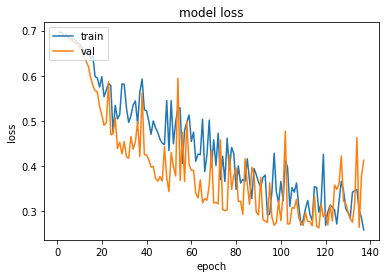

In [24]:
epochs = range(1, len(history.history['acc']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

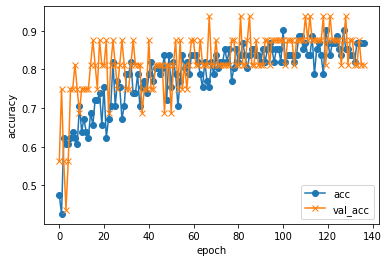

In [25]:
#acc, val_accのプロット
plt.plot(history.history["acc"], label="acc", ls="-", marker="o")
plt.plot(history.history["val_acc"], label="val_acc", ls="-", marker="x")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(loc="best")
#Final.pngという名前で、結果を保存
# plt.savefig('Final.png')
# plt.show()

In [26]:
print("Test accuracy: %.4f" % (model.evaluate(X_test, Y_test)[1]))

16/16 [==============================] - 0s 217us/step
Test accuracy: 0.8750


In [27]:
predict_classes = model.predict_classes(X_test)

In [28]:
Y_test = np.array([np.argmax(x) for x in Y_test])

In [29]:
pd.crosstab(Y_test, predict_classes, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
True,,,
0,10,0,10
1,2,4,6
All,12,4,16
